### Homework 4

### Data preparation


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [241]:
data = 'https://raw.githubusercontent.com/alexeygrigorev/datasets/master/course_lead_scoring.csv'

In [242]:
!wget $data -O data-week-4.csv

--2025-10-19 21:36:21--  https://raw.githubusercontent.com/alexeygrigorev/datasets/master/course_lead_scoring.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 2606:50c0:8002::154, 2606:50c0:8001::154, 2606:50c0:8003::154, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|2606:50c0:8002::154|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 80876 (79K) [text/plain]
Saving to: ‘data-week-4.csv’

data-week-4.csv     100%[===================>]  78.98K  --.-KB/s    in 0.04s   

2025-10-19 21:36:21 (2.17 MB/s) - ‘data-week-4.csv’ saved [80876/80876]



In [243]:
df = pd.read_csv('data-week-4.csv')

In [244]:
df.head()

,lead_source,industry,number_of_courses_viewed,annual_income,employment_status,location,interaction_count,lead_score,converted
0,paid_ads,NaN,1,79450.0,unemployed,south_america,4,0.94,1
1,social_media,retail,1,46992.0,employed,south_america,1,0.80,0
2,events,healthcare,5,78796.0,unemployed,australia,3,0.69,1
3,paid_ads,retail,2,83843.0,NaN,australia,1,0.87,0
4,referral,education,3,85012.0,self_employed,europe,3,0.62,1


- Check if the missing values are presented in the features.
- If there are missing values:
    - For caterogiral features, replace them with 'NA'
    - For numerical features, replace with with 0.0

Split the data into 3 parts: train/validation/test with 60%/20%/20% distribution. Use train_test_split function for that with random_state=1

In [245]:
df.isnull().sum()

lead_source                 128
industry                    134
number_of_courses_viewed      0
annual_income               181
employment_status           100
location                     63
interaction_count             0
lead_score                    0
converted                     0
dtype: int64

In [246]:
df.dtypes

lead_source                  object
industry                     object
number_of_courses_viewed      int64
annual_income               float64
employment_status            object
location                     object
interaction_count             int64
lead_score                  float64
converted                     int64
dtype: object

In [247]:
df.columns

Index(['lead_source', 'industry', 'number_of_courses_viewed', 'annual_income',
       'employment_status', 'location', 'interaction_count', 'lead_score',
       'converted'],
      dtype='object')

In [248]:
df.columns = df.columns.str.lower().str.replace(' ','_')
categorical = list(df.dtypes[df.dtypes == 'object'].index)

for c in categorical:
    df[c] = df[c].str.lower().str.replace(' ','_')

In [249]:
numerical = ['number_of_courses_viewed','annual_income','interaction_count','lead_score']

In [250]:
df[categorical] = df[categorical].fillna('NA')
df[numerical] = df[numerical].fillna(0.0)

In [251]:
df.isnull().sum()

lead_source                 0
industry                    0
number_of_courses_viewed    0
annual_income               0
employment_status           0
location                    0
interaction_count           0
lead_score                  0
converted                   0
dtype: int64

In [252]:
from sklearn.model_selection import train_test_split

In [253]:
df_full_train,df_test = train_test_split(df,test_size=0.2,random_state=1)

In [254]:
df_train,df_val = train_test_split(df_full_train,test_size=0.25,random_state=1)

In [255]:
len(df_full_train),len(df_train),len(df_val),len(df_test)

(1169, 876, 293, 293)

In [256]:
df_train = df_train.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)

In [257]:
y_train = df_train.converted.values
y_test = df_test.converted.values
y_val = df_val.converted.values

In [258]:
del df_train['converted']
del df_test['converted']
del df_val['converted']

In [259]:
df_full_train = df_full_train.reset_index(drop=True)

In [281]:
y_full_train = df_full_train.converted.values

**Question 1. : ROC AUC feature importance**  
Which numerical variable (among the following 4) has the highest AUC?

- lead_score
- number_of_courses_viewed
- interaction_count
- annual_income

In [260]:
from sklearn.metrics import mutual_info_score
from sklearn.metrics import auc
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

In [282]:
auc_results = {}

for col in numerical:
    s = df_full_train[col].values

    auc_raw = roc_auc_score(y_full_train, s)

    if auc_raw < 0.5:
        s = -s
        auc_adj = roc_auc_score(y_full_train, s)
        auc_results[col] = {'auc': auc_adj, 'flipped': True, 'auc_before_flip': auc_raw}
    else:
        auc_results[col] = {'auc': auc_raw, 'flipped': False}

auc_results

{'number_of_courses_viewed': {'auc': 0.7578540402328948, 'flipped': False},
 'annual_income': {'auc': 0.5533332306460059, 'flipped': False},
 'interaction_count': {'auc': 0.7276793690890606, 'flipped': False},
 'lead_score': {'auc': 0.6163611718677798, 'flipped': False}}

In [283]:
sorted_by_values = sorted([(k, v['auc'], v['flipped']) for k, v in auc_results.items()], key=lambda item: item[1],reverse=True)

print(sorted_by_values)

[('number_of_courses_viewed', 0.7578540402328948, False), ('interaction_count', 0.7276793690890606, False), ('lead_score', 0.6163611718677798, False), ('annual_income', 0.5533332306460059, False)]


**Question 2: Training the model**  
Apply one-hot-encoding using DictVectorizer and train the logistic regression with these parameters:

LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)  
What's the AUC of this model on the validation dataset? (round to 3 digits)  

- 0.32
- 0.52
- 0.72
- 0.92

In [284]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression

In [299]:
train_dicts = df_train.to_dict(orient='records')
val_dicts = df_val.to_dict(orient='records')

In [300]:
dv = DictVectorizer(sparse= False)

In [301]:
X_train = dv.fit_transform(train_dicts)
X_val = dv.transform(val_dicts)

In [302]:
model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)

In [303]:
model.fit(X_train,y_train)

LogisticRegression(max_iter=1000, solver='liblinear')

In [304]:
y_pred = model.predict_proba(X_val)[:, 1]
auc = roc_auc_score(y_val, y_pred)

print("Validation AUC:", round(auc, 3))

Validation AUC: 0.817


No same answer in the question

In [305]:
for s in ['liblinear', 'lbfgs', 'saga']:
    model = LogisticRegression(solver=s, C=1.0, max_iter=1000)
    model.fit(X_train, y_train)
    y_pred_val = model.predict_proba(X_val)[:, 1]
    auc = roc_auc_score(y_val, y_pred_val)
    print(f"solver={s:10s}  AUC={auc:.4f}")


solver=liblinear   AUC=0.8171
solver=lbfgs       AUC=0.7810
solver=saga        AUC=0.5588


/Users/yifanliu/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [306]:
for c in [0.01, 0.1, 0.5, 1, 10, 100]:
    model = LogisticRegression(solver='liblinear', C=c, max_iter=1000)
    model.fit(X_train, y_train)
    y_pred_val = model.predict_proba(X_val)[:, 1]
    auc = roc_auc_score(y_val, y_pred_val)
    print(f"C={c:<6} AUC={auc:.4f}")


C=0.01   AUC=0.8279
C=0.1    AUC=0.8175
C=0.5    AUC=0.8172
C=1      AUC=0.8171
C=10     AUC=0.8171
C=100    AUC=0.8171


**Question 3: Precision and Recall**

Now let's compute precision and recall for our model.

Evaluate the model on all thresholds from 0.0 to 1.0 with step 0.01  
For each threshold, compute precision and recall  
Plot them  
At which threshold precision and recall curves intersect?  

- 0.145
- 0.345
- 0.545
- 0.745

In [307]:
thresholds = np.linspace(0,1,101)
thresholds 

array([0.  , 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 ,
       0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21,
       0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32,
       0.33, 0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42, 0.43,
       0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.5 , 0.51, 0.52, 0.53, 0.54,
       0.55, 0.56, 0.57, 0.58, 0.59, 0.6 , 0.61, 0.62, 0.63, 0.64, 0.65,
       0.66, 0.67, 0.68, 0.69, 0.7 , 0.71, 0.72, 0.73, 0.74, 0.75, 0.76,
       0.77, 0.78, 0.79, 0.8 , 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87,
       0.88, 0.89, 0.9 , 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98,
       0.99, 1.  ])

In [308]:
scores = []

for t in thresholds:
    actual_positive = (y_val == 1)
    actual_negative = (y_val ==0)
    
    predict_positive = (y_pred >= t)
    predict_negative = (y_pred < t)
    
    tp = (predict_positive & actual_positive).sum()
    tn = (predict_negative & actual_negative).sum()
    
    fp = (predict_positive & actual_negative).sum()
    fn = (predict_negative & actual_positive).sum()
    
    scores.append((t,tp,fp,fn,tn))
    

In [309]:
columns = ['threshold','tp','fp','fn','tn']
df_scores = pd.DataFrame(scores,columns=columns)
df_scores.head()

,threshold,tp,fp,fn,tn
0,0.00,171,122,0,0
1,0.01,171,122,0,0
2,0.02,171,122,0,0
3,0.03,171,122,0,0
4,0.04,171,122,0,0


In [310]:
df_scores['precision'] = df_scores.tp/(df_scores.tp+df_scores.fp)

df_scores['recall'] = df_scores.tp/(df_scores.tp+df_scores.fn)

In [311]:
df_scores['diff'] = abs(df_scores.precision - df_scores.recall)


In [312]:
best_idx = df_scores['diff'].idxmin()
df_scores.loc[best_idx]

threshold      0.640000
tp           134.000000
fp            38.000000
fn            37.000000
tn            84.000000
precision      0.779070
recall         0.783626
diff           0.004556
Name: 64, dtype: float64

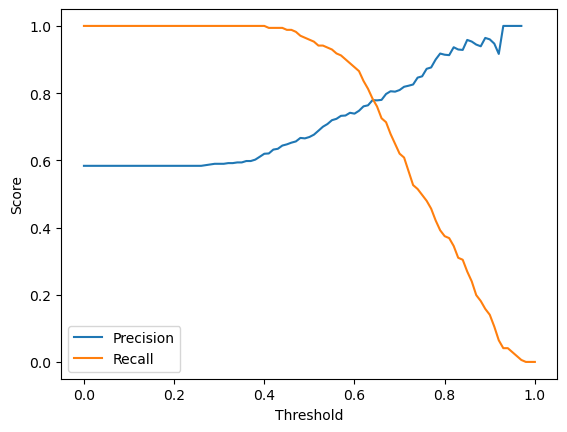

In [313]:
plt.plot(thresholds,df_scores.precision,label='Precision')
plt.plot(thresholds,df_scores.recall,label='Recall')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.legend()
plt.show()

In [314]:
from sklearn.metrics import precision_score, recall_score
precisions = []
recalls = []

for t in thresholds:
    y_pred = (y_pred_val >= t)
    p = precision_score(y_val, y_pred)
    r = recall_score(y_val, y_pred)
    precisions.append(p)
    recalls.append(r)

/Users/yifanliu/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/yifanliu/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/yifanliu/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


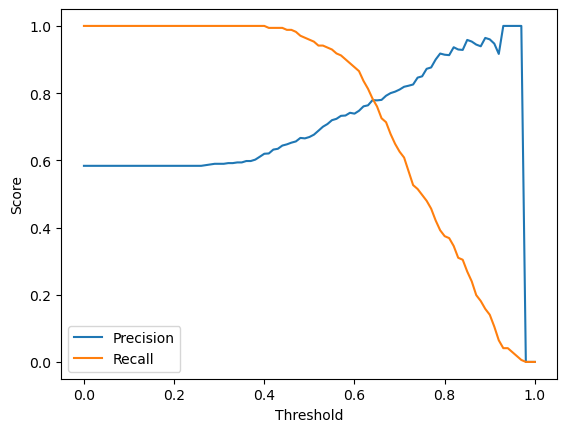

In [315]:
plt.plot(thresholds,precisions,label='Precision')
plt.plot(thresholds,recalls,label='Recall')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.legend()
plt.show()

I have used two methods to compute the intersect point, they are both between 0.6 and 0.8, no answer in the options.

In [316]:
model_lbfgs = LogisticRegression(solver='lbfgs', C=1.0, max_iter=10000)

In [317]:
model_lbfgs.fit(X_train, y_train)
y_pred_lbfgs = model_lbfgs.predict_proba(X_val)[:, 1]

In [318]:
def precision_recall(y_pred):
    precisions = []
    recalls = []
    for t in thresholds:
        y_pred = (y_pred_val >= t)
        p = precision_score(y_val, y_pred)
        r = recall_score(y_val, y_pred)
        precisions.append(p)
        recalls.append(r)
    return precisions,recalls

In [319]:
lbfgs_precisions,lbfgs_recalls = precision_recall(y_pred_lbfgs)

/Users/yifanliu/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/yifanliu/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/yifanliu/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


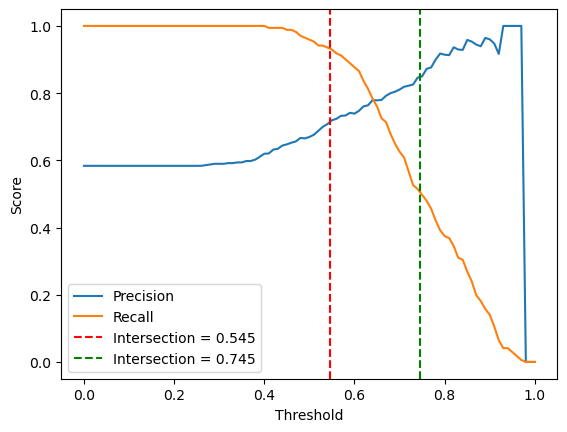

In [320]:
plt.plot(thresholds,lbfgs_precisions,label='Precision')
plt.plot(thresholds,lbfgs_recalls,label='Recall')
best_threshold1 = 0.545
best_threshold2 = 0.745
plt.axvline(best_threshold1, color='red', linestyle='--', label=f'Intersection = {best_threshold1:.3f}')
plt.axvline(best_threshold2, color='green', linestyle='--', label=f'Intersection = {best_threshold2:.3f}')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.legend()
plt.show()

**Question 4: F1 score**

Precision and recall are conflicting - when one grows, the other goes down. That's why they are often combined into the F1 score - a metrics that takes into account both

This is the formula for computing F1:

$F_1 = 2\cdot\frac{P \cdot R}{P + R}$

Where `P` is precision and `R` is recall.

Let's compute F1 for all thresholds from 0.0 to 1.0 with increment 0.01

At which threshold F1 is maximal?

- 0.14
- 0.34
- 0.54
- 0.74

In [321]:
df_scores['f1'] = 2 * df_scores.precision * df_scores.recall / (df_scores.precision + df_scores.recall)


Best threshold: 0.570
Max F1 score: 0.812


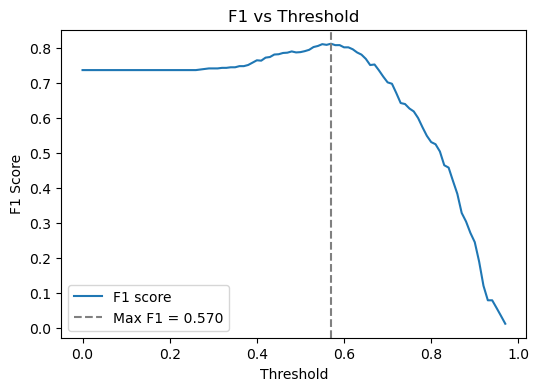

In [322]:

df_scores['f1'] = 2 * df_scores.precision * df_scores.recall / (df_scores.precision + df_scores.recall)


best_idx = df_scores.f1.idxmax()
best_threshold = df_scores.loc[best_idx, 'threshold']
best_f1 = df_scores.loc[best_idx, 'f1']

print(f"Best threshold: {best_threshold:.3f}")
print(f"Max F1 score: {best_f1:.3f}")



plt.figure(figsize=(6,4))
plt.plot(df_scores.threshold, df_scores.f1, label='F1 score')
plt.axvline(best_threshold, color='gray', linestyle='--', label=f'Max F1 = {best_threshold:.3f}')
plt.xlabel('Threshold')
plt.ylabel('F1 Score')
plt.title('F1 vs Threshold')
plt.legend()
plt.show()


From the above plot, the most close option is 0.54

**Question 5: 5-Fold CV**

Use the KFold class from Scikit-Learn to evaluate our model on 5 different folds:

KFold(n_splits=5, shuffle=True, random_state=1)

Iterate over different folds of df_full_train

Split the data into train and validation

Train the model on train with these parameters: LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)

Use AUC to evaluate the model on validation

How large is standard deviation of the scores across different folds?

- 0.0001
- 0.006
- 0.06
- 0.36

In [327]:
def train(df_train,y_train,C=1.0):
    dicts = df_train.to_dict(orient='records')
    
    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)
    
    model = LogisticRegression(solver='liblinear',C=C,max_iter=1000)
    model.fit(X_train,y_train)
    
    return dv,model

In [328]:
def predict(df,dv,model):
    dicts = df.to_dict(orient='records')
    
    X=dv.transform(dicts)
    
    y_pred = model.predict_proba(X)[:,1]
    
    return y_pred

In [329]:
from sklearn.model_selection import KFold
kFold = KFold(n_splits=5,shuffle=True,random_state=1)

In [330]:
scores = []

df_full_train = df_full_train.reset_index(drop=True)

for train_idx,val_idx in kFold.split(df_full_train):
    df_train = df_full_train.iloc[train_idx]
    df_val = df_full_train.iloc[val_idx]

    y_train = df_train.converted.values
    y_val = df_val.converted.values

    dv,model = train(df_train,y_train,C=1.0)
    y_pred = predict(df_val,dv,model)


    auc = roc_auc_score(y_val,y_pred)

    scores.append(auc)

print("AUCs on 5 folds:", np.round(scores, 4))
print("Mean AUC:", round(np.mean(scores), 4))
print("Std of AUC:", round(np.std(scores), 4))

AUCs on 5 folds: [0.8688 0.9217 0.8434 0.8422 0.9026]
Mean AUC: 0.8757
Std of AUC: 0.0318


My 5-Fold CV standard deviation is 0.0318, just can choose the close option 0.06

**Question 6: Hyperparameter Tuning**

Now let's use 5-Fold cross-validation to find the best parameter C

Iterate over the following C values: [0.000001, 0.001, 1]

Initialize KFold with the same parameters as previously

Use these parameters for the model: LogisticRegression(solver='liblinear', C=C, max_iter=1000)

Compute the mean score as well as the std (round the mean and std to 3 decimal digits)

Which C leads to the best mean score?

- 0.000001
- 0.001
- 1

If you have ties, select the score with the lowest std. If you still have ties, select the smallest C.



In [332]:
from tqdm.auto import tqdm
n_splits = 5

for C in tqdm([0.000001, 0.001, 1]):
    kFold = KFold(n_splits=n_splits,shuffle=True,random_state=1)
    
    scores = []
    for train_idx,val_idx in kFold.split(df_full_train):
        df_train = df_full_train.iloc[train_idx]
        df_val = df_full_train.iloc[val_idx]

        y_train = df_train.converted.values
        y_val = df_val.converted.values

        dv,model = train(df_train,y_train,C=C)
        y_pred = predict(df_val,dv,model)


        auc = roc_auc_score(y_val,y_pred)

        scores.append(auc)

    print('C=%s %.3f +- %.3f' % (C,np.mean(scores),np.std(scores)))

  0%|          | 0/3 [00:00<?, ?it/s]

C=1e-06 0.561 +- 0.024
C=0.001 0.926 +- 0.018
C=1 0.876 +- 0.032


 From the above result, we can observe that when C is `0.001`, the mean value is the maximum and the standard value is the minimum